In [1]:
import pandas as pd
import numpy as np
import glob
import re
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from recursive_selection import FeatureSelector
import warnings
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.decomposition import PCA

# Extract Moneylines and Merge DataFrames

In [2]:
#get file paths for MLB betting data
all_files = glob.glob('./historical_odds/*.xlsx')

#create dictionary to store dataframes 
odds_by_season = {}

#iterate over all .XSLX files
for file in all_files:
    #extract year from file name using regex
    match_pattern = '([\d]{4})'
    year = re.findall(match_pattern, file)[0]
    #years before 2014 do not have the run line, will worry about those ones later
    if int(year) < 2014:
        season_odds = pd.read_excel(file)
        season_odds = season_odds.rename(columns = {'Unnamed: 18' : 'open_TJ',
                                                   'Unnamed: 20' : 'close_TJ'})
        season_odds['Date'] = season_odds['Date'].astype('str')
        season_odds['Date'] = season_odds['Date'] + year
        season_odds['Date'] = pd.to_datetime(season_odds['Date'], format = '%m%d%Y')
        col_selected = season_odds[['Date', 'VH', 'Team', 'Open', 'Close', 'Open OU',
                               'open_TJ', 'Close OU', 'close_TJ']]
        home_teams = col_selected[col_selected.VH == 'H'].reset_index(drop = True)
        road_teams = col_selected[col_selected.VH == 'V'].reset_index(drop = True)
        
        home_cols = ['date', 'home_flag', 'team1', 'home_opening', 'home_closing', 'home_open_ou',
                     'home_open_TJ', 'home_close_ou', 'home_close_TJ']
        road_cols = ['date', 'home_flag', 'team2', 'road_opening', 'road_closing', 
                     'road_open_ou', 'road_open_TJ', 'road_close_ou', 'road_close_TJ']
        home_teams.columns = home_cols
        road_teams.columns = road_cols
        
        #drop redundant columns (from both), drop date from road frame 
        home_teams = home_teams.drop(columns = ['home_flag'])
        road_teams = road_teams.drop(columns = ['date', 'home_flag'])
        
        #merge home and road datafames
        full_season = pd.concat([home_teams, road_teams], axis = 1)
        full_season = full_season.assign(is_doubleheader = 0)
        game_counts = full_season.groupby('team1').date.value_counts()
        double_headers = game_counts[game_counts == 2]

        all_double_headers = []
        for j in double_headers.index:
            all_double_headers.append(j)

        for index in all_double_headers:
            game_indices = full_season[(full_season.team1 == index[0]) & (full_season.date == index[1])].index
            if len(game_indices) > 1:
                full_season.at[game_indices[1], 'is_doubleheader'] = 1
            else:
                print(index)
        #add to dataframe dict
        odds_by_season[year] = full_season
        
    else:       
        season_odds = pd.read_excel(file)
        #rename juice columns
        season_odds = season_odds.rename(columns = {'Unnamed: 18' : 'runline_juice',
                                           'Unnamed: 20' : 'open_TJ',
                                           'Unnamed: 22' : 'close_TJ'})
        #convert date to str, add in year which is missing, convert date column to datetime object
        season_odds['Date'] = season_odds['Date'].astype('str')
        season_odds['Date'] = season_odds['Date'] + year
        season_odds['Date'] = pd.to_datetime(season_odds['Date'], format = '%m%d%Y')
        #extract meaningful columns
        col_selected = season_odds[['Date', 'VH', 'Team', 'Open', 'Close', 'Run Line', 'runline_juice', 'Open OU',
                                   'open_TJ', 'Close OU', 'close_TJ']]
        #split frame into neutral, road, and home games
        home_teams = col_selected[col_selected.VH == 'H'].reset_index(drop = True)
        road_teams = col_selected[col_selected.VH == 'V'].reset_index(drop = True)

        #rename home and road dataframe feature sets
        home_cols = ['date', 'home_flag', 'team1', 'home_opening', 'home_closing', 'home_runline', 
                    'home_runline_juice', 'home_open_ou', 'home_open_TJ', 'home_close_ou', 'home_close_TJ']
        road_cols = ['date', 'home_flag', 'team2', 'road_opening', 'road_closing', 'road_runline', 
                    'road_runline_juice', 'road_open_ou', 'road_open_TJ', 'road_close_ou', 'road_close_TJ']
        home_teams.columns = home_cols
        road_teams.columns = road_cols

        #drop redundant columns (from both), drop date from road frame 
        home_teams = home_teams.drop(columns = ['home_flag'])
        road_teams = road_teams.drop(columns = ['date', 'home_flag'])

        #merge home and road datafames
        full_season = pd.concat([home_teams, road_teams], axis = 1)

        #add feature for second game of double headers (this is necessary for merging later)
        full_season = full_season.assign(is_doubleheader = 0)
        game_counts = full_season.groupby('team1').date.value_counts()
        double_headers = game_counts[game_counts == 2]

        all_double_headers = []
        for j in double_headers.index:
            all_double_headers.append(j)

        for index in all_double_headers:
            game_indices = full_season[(full_season.team1 == index[0]) & (full_season.date == index[1])].index
            if len(game_indices) > 1:
                full_season.at[game_indices[1], 'is_doubleheader'] = 1
            else:
                print(index)
        #add to dataframe dict
        odds_by_season[year] = full_season

In [3]:
#create baseline list of teams
base_teams = odds_by_season['2010'].team1.unique()

#create list to store tuples of problem team codes
problem_teams = []
#iterate through all keys and check for problem team codes (mistyped, changed name, etc.)
for key in odds_by_season.keys():
    home_teams = list(odds_by_season[key].team1.unique())
    road_teams = list(odds_by_season[key].team2.unique())
    for team in home_teams:
        if team not in base_teams:
            problem_teams.append((key, team))
    for team in road_teams:
        if team not in base_teams:
            problem_teams.append((key, team))
#view problem teams
problem_teams

[('2018', 'LAD'),
 ('2018', 'LAD'),
 ('2019', 'LAD'),
 ('2019', 'HOW'),
 ('2019', 'LAD'),
 ('2016', 'LAD')]

In [4]:
#create dict
trouble_dict = {'LOS' : 'LAD',
               'HOW' : 'HOU'}
#iterate through all dataframes
for key in odds_by_season.keys():
    odds_by_season[key] = odds_by_season[key].replace({'team1' : trouble_dict,
                                                      'team2' : trouble_dict})
    print(len(odds_by_season[key].team1.unique()))

30
30
30
30
30
30
30
30
30
30


In [5]:
#read in primary dataframe 
primary_df = pd.read_csv('./all_features.csv.gz', compression = 'gzip')

#prepare primary dataframe 
primary_df['date'] = pd.to_datetime(primary_df['date'], format = '%Y-%m-%d')
primary_df['year'] = pd.DatetimeIndex(primary_df['date']).year
elo_codes = list(primary_df.team1.unique())

In [6]:
#empty list for trouble_elo codes
elo_trouble = []

#iterate through dataframes
for key in odds_by_season.keys():
    team_codes = list(odds_by_season[key].team1.unique())
    for team in team_codes:
        if team not in elo_codes and team not in elo_trouble:
            elo_trouble.append(team)
#view results
elo_trouble

['MIA', 'CUB', 'SDG', 'TAM', 'LAA', 'WAS', 'SFO', 'CWS', 'KAN']

In [7]:
#create dictionary mapping to elo team codes
elo_map = {'WAS' : 'WSN',
         'SDG' : 'SDP',
         'MIA' : 'FLA',
         'TAM' : 'TBD',
         'KAN' : 'KCR',
         'LAA' : 'ANA',
         'SFO' : 'SFG',
         'CWS' : 'CHW',
         'CUB' : 'CHC'}
#iterate through all dataframes
for key in odds_by_season.keys():
    odds_by_season[key] = odds_by_season[key].replace({'team1' : elo_map,
                                                      'team2' : elo_map})
    print(len(odds_by_season[key].team1.unique()))

30
30
30
30
30
30
30
30
30
30


In [8]:
#create empty list to store dataframes
completed_frames = []

#create list of merge keys
merge_keys = ['date', 'team1', 'team2', 'is_doubleheader']
#iterate through df dict
for key in odds_by_season.keys():
    season_elo = primary_df[primary_df.year == int(key)].reset_index(drop = True)
    completed = season_elo.merge(odds_by_season[key], how = 'left', left_on = merge_keys, right_on = merge_keys)
    completed_frames.append(completed)
    print(len(completed[completed.home_opening.isnull()]))

0
0
0
5
0
4
2
0
0
0


In [9]:
runline_frames = []
moneyline_frames = []
for frame in completed_frames:
    if frame.year.max() >= 2014:
        runline_frames.append(frame)
        frame = frame.drop(columns = ['home_runline', 'home_runline_juice', 'road_runline', 'road_runline_juice'])
    moneyline_frames.append(frame)
del completed_frames
moneyline_frame = pd.concat(moneyline_frames, axis = 0, sort = False)
runline_frames = pd.concat(runline_frames, axis = 0, sort = False)

In [10]:
#drop rows with null values
moneyline_frame = moneyline_frame.dropna(axis = 0, how = 'any')
runline_frames = runline_frames.dropna(axis = 0, how = 'any')
#sort by date
moneyline_frame = moneyline_frame.sort_values(by = ['date']).reset_index(drop = True)
runline_frames = runline_frames.sort_values(by = ['date']).reset_index(drop = True)

moneyline_frame.head()

,date,is_doubleheader,is_tripleheader,home_OBPS,home_AVG_RUNS,home_AVG_H,home_BULLPEN_ERA,home_BULLPEN_WHIP,home_BULLPEN_AVG_INNINGS,home_total_OBPS,...,home_open_ou,home_open_TJ,home_close_ou,home_close_TJ,road_opening,road_closing,road_open_ou,road_open_TJ,road_close_ou,road_close_TJ
0,2010-04-04,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,-104.0,9,-115.0,104,107.0,9.0,-116.0,9,-105.0
1,2010-04-05,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.5,-110.0,8.5,-120.0,115,110.0,8.5,-110.0,8.5,100.0
2,2010-04-05,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.5,-115.0,7.5,-125.0,110,-105.0,7.5,-105.0,7.5,105.0
3,2010-04-05,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.5,100.0,8.5,110.0,120,113.0,8.5,-120.0,8.5,-130.0
4,2010-04-05,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.5,-115.0,9,100.0,120,135.0,9.5,-105.0,9,-120.0


In [11]:
#isolate odds features to view data 
odds_features = list(moneyline_frame.columns[105:])

In [12]:
odds_frame = moneyline_frame[odds_features]
odds_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24257 entries, 0 to 24256
Data columns (total 12 columns):
home_opening     24257 non-null object
home_closing     24257 non-null float64
home_open_ou     24257 non-null float64
home_open_TJ     24257 non-null float64
home_close_ou    24257 non-null object
home_close_TJ    24257 non-null float64
road_opening     24257 non-null object
road_closing     24257 non-null float64
road_open_ou     24257 non-null float64
road_open_TJ     24257 non-null float64
road_close_ou    24257 non-null object
road_close_TJ    24257 non-null float64
dtypes: float64(8), object(4)
memory usage: 2.2+ MB


In [13]:
try:
    odds_frame['home_opening'].astype('float64')
except Exception as e:
    print(e)
try:
    odds_frame['road_opening'].astype('float64')
except Exception as e:
    print(e)
try:
    odds_frame['home_close_ou'].astype('float64')
except Exception as e:
    print(e)

could not convert string to float: 'NL'
could not convert string to float: 'NL'
could not convert string to float: '8½'


In [14]:
odds_frame[odds_frame.home_opening == 'NL']

,home_opening,home_closing,home_open_ou,home_open_TJ,home_close_ou,home_close_TJ,road_opening,road_closing,road_open_ou,road_open_TJ,road_close_ou,road_close_TJ
22044,NL,-119.0,8.5,-110.0,9,-120.0,NL,109.0,8.5,-110.0,9,100.0
22101,NL,-250.0,8.5,-110.0,8.5,-105.0,NL,220.0,8.5,-110.0,8.5,-115.0
22138,NL,-134.0,7.5,-110.0,8.5,-120.0,NL,124.0,7.5,-110.0,8.5,100.0
22240,NL,110.0,8.5,-110.0,8,-115.0,NL,-120.0,8.5,-110.0,8,-105.0
22273,NL,200.0,8.5,-110.0,8,-110.0,NL,-220.0,8.5,-110.0,8,-110.0


In [15]:
odds_frame[odds_frame.home_close_ou == '8½']

,home_opening,home_closing,home_open_ou,home_open_TJ,home_close_ou,home_close_TJ,road_opening,road_closing,road_open_ou,road_open_TJ,road_close_ou,road_close_TJ
2309,100,-122.0,8.5,-110.0,8½,-120.0,-110,112.0,8.5,-110.0,8½,100.0
2310,-115,-121.0,8.0,-105.0,8½,-105.0,105,111.0,8.0,-115.0,8½,-115.0
2314,-135,-160.0,9.0,-110.0,8½,100.0,120,140.0,9.0,-110.0,8½,-120.0
2319,-210,-200.0,9.0,-110.0,8½,100.0,185,175.0,9.0,-110.0,8½,-120.0
2320,-210,-230.0,8.5,-110.0,8½,-120.0,185,205.0,8.5,-110.0,8½,100.0


In [16]:
odds_frame[odds_frame.home_close_ou.str.contains('½', na = False)]

,home_opening,home_closing,home_open_ou,home_open_TJ,home_close_ou,home_close_TJ,road_opening,road_closing,road_open_ou,road_open_TJ,road_close_ou,road_close_TJ
2309,100,-122.0,8.5,-110.0,8½,-120.0,-110,112.0,8.5,-110.0,8½,100.0
2310,-115,-121.0,8.0,-105.0,8½,-105.0,105,111.0,8.0,-115.0,8½,-115.0
2314,-135,-160.0,9.0,-110.0,8½,100.0,120,140.0,9.0,-110.0,8½,-120.0
2317,115,101.0,8.0,-120.0,7½,-105.0,-130,-111.0,8.0,100.0,7½,-115.0
2319,-210,-200.0,9.0,-110.0,8½,100.0,185,175.0,9.0,-110.0,8½,-120.0
2320,-210,-230.0,8.5,-110.0,8½,-120.0,185,205.0,8.5,-110.0,8½,100.0
2322,-140,-200.0,10.5,-120.0,9½,-120.0,125,175.0,10.5,100.0,9½,100.0


In [17]:
m = str(odds_frame.iloc[2322]['home_close_ou']).split('½')[0]
t = float(m + ".5")
t

9.5

In [18]:
def problem_values(df, val1, val2):
    problem_indices1 = set(df[(df.home_opening == val1) | (df.road_opening == val1)].index)
    problem_indices2 = set(df[(df.home_close_ou.str.contains(val2, na = False)) | 
                             (df.road_close_ou.str.contains(val2, na = False))].index)
    for index in problem_indices1:
        df.at[index, 'home_opening'] = df.iloc[index]['home_closing']
        df.at[index, 'road_opening'] = df.iloc[index]['road_closing']
    for index in problem_indices2:
        n = df.iloc[index]['home_close_ou'].split(val2)[0]
        n = float(n + ".5")
        df.at[index, 'home_close_ou'] = n
        m = df.iloc[index]["road_close_ou"].split(val2)[0]
        m = float(m + ".5")
        df.at[index, "road_close_ou"] = m
    return(df)

In [19]:
moneyline_frame = problem_values(moneyline_frame, "NL", '½')

In [20]:
moneyline_frame['home_opening'] = moneyline_frame.home_opening.astype("float64")
moneyline_frame["road_opening"] = moneyline_frame.road_opening.astype("float64")
moneyline_frame["home_close_ou"] = moneyline_frame.home_close_ou.astype("float64")
moneyline_frame["road_close_ou"] = moneyline_frame.road_close_ou.astype("float64")

In [21]:
#check datatypes
groups = moneyline_frame.columns.to_series().groupby(moneyline_frame.dtypes).groups

In [22]:
groups

{dtype('<M8[ns]'): Index(['date'], dtype='object'),
 dtype('int64'): Index(['is_doubleheader', 'is_tripleheader', 'home_loss', 'year'], dtype='object'),
 dtype('float64'): Index(['home_OBPS', 'home_AVG_RUNS', 'home_AVG_H', 'home_BULLPEN_ERA',
        'home_BULLPEN_WHIP', 'home_BULLPEN_AVG_INNINGS', 'home_total_OBPS',
        'home_total_AVG_RUNS', 'home_total_AVG_H', 'home_total_BULLPEN_ERA',
        ...
        'home_open_ou', 'home_open_TJ', 'home_close_ou', 'home_close_TJ',
        'road_opening', 'road_closing', 'road_open_ou', 'road_open_TJ',
        'road_close_ou', 'road_close_TJ'],
       dtype='object', length=108),
 dtype('O'): Index(['home_starter', 'road_starter', 'team1', 'team2'], dtype='object')}

In [23]:
#drop needless columns 
moneyline_frame = moneyline_frame.drop(columns = ['is_doubleheader', 'is_tripleheader', 'year', 
                                                 'home_starter', 'road_starter', 'team1', 'team2','road_open_ou', 
                                                  'road_open_TJ', 'road_close_ou', 'road_close_TJ'])

moneyline_frame = moneyline_frame.rename(columns = {'home_open_ou' : 'total_open', 
                                                   'home_open_TJ' : 'total_openJ', 
                                                   'home_close_ou' : 'total_close', 
                                                   'home_close_TJ' : 'total_closeJ'})

In [24]:
moneyline_frame['home_win'] = (moneyline_frame.home_loss == 0).astype('uint8')
moneyline_frame = moneyline_frame.drop(columns = ['home_loss'])

# END DATA PREP

In [26]:
moneyline_frame = pd.read_csv('./moneyline_frame.csv.gz', compression = 'gzip')

In [27]:
#add year feature (I know I just dropped it, but to save the dataframe I would prefer to keep the date feature)
moneyline_frame['year'] = pd.DatetimeIndex(moneyline_frame.date).year
moneyline_frame = moneyline_frame.drop(columns = ['elo_prob2', 'rating_prob2','roof_closed', 
                                                  'is_retractable', 'is_wildcard', 'is_divisional','is_championship',
                                                  'is_world_series','is_daygame','is_march','is_april','is_may',
                                                  'is_june','is_july', 'is_august', 'is_september', 'is_october', 
                                                  'is_november'])

In [28]:
def calculate_totalpayout(df):
    ''' 
    Assuming $1.00 bet for simplicity
    '''
    home_outcome = []
    road_outcome = []
    for k in range(len(df)):
        if df.iloc[k]['home_closing'] < 0:
            home_outcome.append(-100.0 / df.iloc[k]['home_closing'] + 1)
        else:
            home_outcome.append(df.iloc[k]['home_closing'] / 100 + 1)
        if df.iloc[k]['road_closing'] < 0:
            road_outcome.append(-100.0 / df.iloc[k]['road_closing'] + 1)
        else:
            road_outcome.append(df.iloc[k]['road_closing'] / 100 + 1)
    return(pd.Series(home_outcome), pd.Series(road_outcome))

home_payout, road_payout = calculate_totalpayout(moneyline_frame)
moneyline_frame['home_payout'], moneyline_frame['road_payout'] = home_payout, road_payout

In [29]:
moneyline_frame.to_csv('./moneyline_frame.csv.gz', index = False, compression = 'gzip')

In [5]:
#split by years- attempting to model the 2019 season 
Train = moneyline_frame[moneyline_frame.year < 2019].reset_index(drop = True)
Test = moneyline_frame[moneyline_frame.year == 2019].reset_index(drop = True)
Train = Train.drop(columns = ['year'])
Test = Test.drop(columns = ['year'])

In [6]:
#drop score columns 
Train = Train.drop(columns = ['score1', 'score2'])
Test = Test.drop(columns = ['score1', 'score2'])

# Proof of concept

In [7]:
train_features = np.array(Train.drop(columns = ['date','home_win']))
train_target = np.array(Train['home_win'])
test_features = np.array(Test.drop(columns = ['date','home_win']))
test_target = np.array(Test['home_win'])

In [8]:
train_target = train_target.astype('float32')

In [9]:
n_cols = train_features.shape[1]

In [10]:
#train base model with base architecture.. this is a proof of concept test, if there are viable results here
#we will move on to tuning parameters and architecture
base_model = Sequential()
base_model.add(Dense(50, activation = 'relu', input_shape = (n_cols,)))
base_model.add(Dense(50, activation = 'relu'))
base_model.add(Dense(50, activation = 'relu'))
base_model.add(Dense(1, activation = 'sigmoid'))

base_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['binary_accuracy'])

base_model.fit(train_features, train_target, epochs = 50, validation_split = 0.2)

Train on 17466 samples, validate on 4367 samples
Epoch 1/50
17466/17466 [==============================] - 2s 90us/sample - loss: 16.8631 - binary_accuracy: 0.5089 - val_loss: 11.3747 - val_binary_accuracy: 0.4719
Epoch 2/50
17466/17466 [==============================] - 1s 50us/sample - loss: 9.1728 - binary_accuracy: 0.5122 - val_loss: 27.4670 - val_binary_accuracy: 0.5324
Epoch 3/50
17466/17466 [==============================] - 1s 50us/sample - loss: 6.1955 - binary_accuracy: 0.5093 - val_loss: 12.8717 - val_binary_accuracy: 0.4681
Epoch 4/50
17466/17466 [==============================] - 1s 51us/sample - loss: 4.8535 - binary_accuracy: 0.5113 - val_loss: 0.9917 - val_binary_accuracy: 0.5386
Epoch 5/50
17466/17466 [==============================] - 1s 50us/sample - loss: 3.9099 - binary_accuracy: 0.5147 - val_loss: 8.9301 - val_binary_accuracy: 0.4690
Epoch 6/50
17466/17466 [==============================] - 1s 51us/sample - loss: 2.3957 - binary_accuracy: 0.5167 - val_loss: 0.9513

In [11]:
base_preds = base_model.predict(test_features)
base_preds = [i[0] for i in base_preds]

In [12]:
class BankrollCalculator():
    def __init__(self, predict_proba, labels, home_closing, road_closing, unit = 100.0, with_juice = False, 
                 style = 'all', upper_tol = 0.6, lower_tol = 0.4):
        self.predict_proba = predict_proba
        self.labels = labels
        self.home_closing = home_closing
        self.road_closing = road_closing
        self.unit = unit
        self.with_juice = with_juice
        self.style = style
        self.upper_tol = upper_tol
        self.lower_tol = lower_tol
        self.plays = None
        self.outcomes = []
        self.play_indices = None
        self.home_reduced = None
        self.road_reduced = None
        self.labels_reduced = None
        
        
    def play_all(self):
        self.get_binary()
        for k in range(len(self.plays)):
            if self.plays[k] and self.labels[k]:
                if self.home_closing.iloc[k] > 0:
                    self.outcomes.append((self.home_closing.iloc[k] / 100.) * self.unit)
                else:
                    if self.with_juice:
                        self.outcomes.append(self.unit)
                    else:
                        self.outcomes.append((100. / (-1 * self.home_closing.iloc[k])) * self.unit)
            
            elif self.plays[k] and not self.labels[k]:
                if self.with_juice and self.home_closing.iloc[k] < 0:
                    self.outcomes.append((self.home_closing.iloc[k] / 100.) * self.unit)
                else:
                    self.outcomes.append(-self.unit)
            
            elif not self.plays[k] and not self.labels[k]:
                if self.road_closing.iloc[k] > 0:
                    self.outcomes.append((self.road_closing.iloc[k] / 100.) * self.unit)
                else:
                    if self.with_juice:
                        self.outcomes.append(self.unit)
                    else:
                        self.outcomes.append((100. / (-1 * self.road_closing.iloc[k])) * self.unit)
            else:
                if self.with_juice and self.road_closing.iloc[k] < 0:
                    self.outcomes.append((self.road_closing.iloc[k] / 100.) * self.unit)
                else:
                    self.outcomes.append(-self.unit)
    
    def play_some(self):
        self.get_plays()
        for k in range(len(self.plays)):
            if self.plays[k] and self.labels_reduced.iloc[k]:
                if self.home_reduced.iloc[k] > 0:
                    self.outcomes.append((self.home_reduced.iloc[k] / 100.) * self.unit)
                else:
                    if self.with_juice:
                        self.outcomes.append(self.unit)
                    else:
                        self.outcomes.append((100. / (-1 * self.home_reduced.iloc[k])) * self.unit)
            
            elif self.plays[k] and not self.labels_reduced.iloc[k]:
                if self.with_juice and self.home_reduced.iloc[k] < 0:
                    self.outcomes.append((self.home_reduced.iloc[k] / 100.) * self.unit)
                else:
                    self.outcomes.append(-self.unit)
            
            elif not self.plays[k] and not self.labels_reduced.iloc[k]:
                if self.road_reduced.iloc[k] > 0:
                    self.outcomes.append((self.road_reduced.iloc[k] / 100.) * self.unit)
                else:
                    if self.with_juice:
                        self.outcomes.append(self.unit)
                    else:
                        self.outcomes.append((100. / (-1 * self.road_reduced.iloc[k])) * self.unit)
            else:
                if self.with_juice and self.road_reduced.iloc[k] < 0:
                    self.outcomes.append((self.road_reduced.iloc[k] / 100.) * self.unit)
                else:
                    self.outcomes.append(-self.unit)
        print('REMINDER! You selected the .play_some method... Extract play indices with .play_indices attr')
        

    def get_binary(self):
        self.plays = [1 if i > 0.5 else 0 for i in self.predict_proba]
    
    def get_plays(self):
        _proba = pd.Series(self.predict_proba)
        self.play_indices = list(_proba[(_proba > self.upper_tol) |
                                              (_proba < self.lower_tol)].index)
        
        self.plays = [1 if i > 0.5 else 0 for i in _proba.iloc[self.play_indices]]
        self.home_reduced = self.home_closing.iloc[self.play_indices].reset_index(drop = True)
        self.road_reduced = self.road_closing.iloc[self.play_indices].reset_index(drop = True)
        self.labels_reduced = pd.Series(self.labels).iloc[self.play_indices].reset_index(drop = True)
        
        
        
        

/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


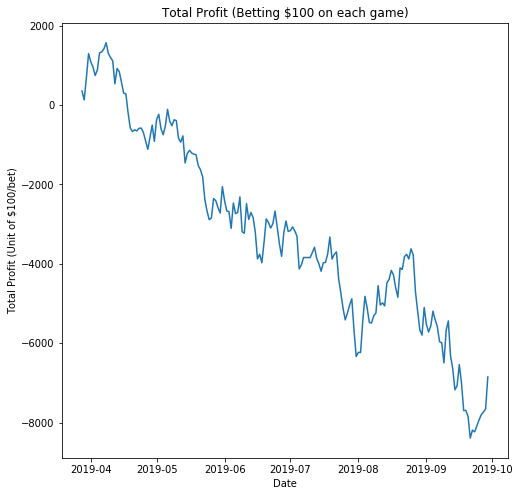

In [13]:
BC = BankrollCalculator(base_preds, test_target, Test['home_closing'], Test['road_closing'])
BC.play_all()

results_series = pd.Series(BC.outcomes)
result_tracking = pd.concat([Test.date, results_series], axis = 1)
result_tracking = result_tracking.rename(columns = {0 : 'outcome'})
result_tracking['date'] = pd.to_datetime(result_tracking['date'], format = '%Y-%m-%d')
result_tracking = result_tracking.set_index('date')
daily_ = result_tracking.resample('D').sum()
daily_['tracker'] = daily_.outcome.cumsum()

#plot baseline betting 
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(daily_.index, daily_.tracker)
ax.set_xlabel('Date')
ax.set_ylabel('Total Profit (Unit of $100/bet)')
ax.set_title('Total Profit (Betting $100 on each game)');


REMINDER! You selected the .play_some method... Extract play indices with .play_indices attr


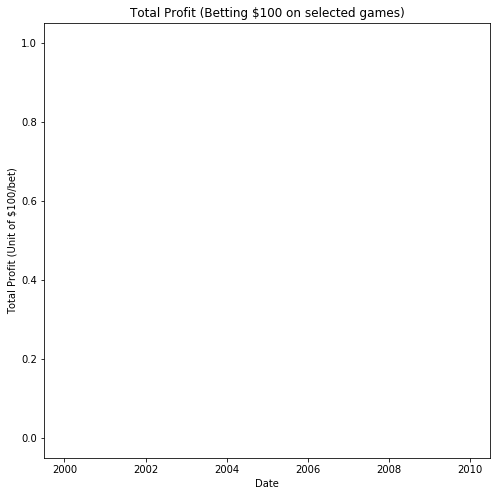

In [14]:
del result_tracking
BC = BankrollCalculator(base_preds, test_target, Test['home_closing'], Test['road_closing'])
BC.play_some()

results_series = pd.Series(BC.outcomes)
play_indices = BC.play_indices
play_dates = Test.date.iloc[play_indices].reset_index(drop = True)
result_tracking = pd.concat([play_dates, results_series], axis = 1)
result_tracking = result_tracking.rename(columns = {0 : 'outcome'})
result_tracking['date'] = pd.to_datetime(result_tracking['date'], format = '%Y-%m-%d')
result_tracking = result_tracking.set_index('date')
daily_ = result_tracking.resample('D').sum()
daily_['tracker'] = daily_.outcome.cumsum()

#plot baseline betting 
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(daily_.index, daily_.tracker)
ax.set_xlabel('Date')
ax.set_ylabel('Total Profit (Unit of $100/bet)')
ax.set_title('Total Profit (Betting $100 on selected games)');

In [15]:
#analyze results
results = pd.Series(BC.outcomes)
num_underdogs = len(results[results > 100.])

underdog_wins = Test[((Test.home_opening > 0) & (Test.home_win == 1)) |
                    ((Test.road_closing > 0) & (Test.home_win == 0))]
print("The underdogs won %.2f percent of games." %(len(underdog_wins)/len(Test)))
print("The model predicted %.2f" %(num_underdogs/len(Test)))

The underdogs won 0.35 percent of games.
The model predicted 0.00


In [16]:
base_preds = pd.Series(base_preds)
base_preds.value_counts()

0.534391    2424
dtype: int64

The model predicted the same value for each input. Clearly, the model is learning nothing and just predicting the higher class. Now, I will look at selecting features as well as evaluating for outliers. 

In [17]:
selected_ = ['home_OBPS', 'home_AVG_RUNS', 'home_AVG_H', 'home_BULLPEN_ERA', 'home_BULLPEN_WHIP', 
            'road_OBPS', 'road_AVG_RUNS', 'road_AVG_H', 'road_BULLPEN_ERA', 'road_BULLPEN_WHIP',
            'home_career_ERA_AH', 'home_career_WHIP_AH', 'home_season_ERA_AH', 'home_season_ERA_AH', 
            'road_career_ERA_OR', 'road_career_WHIP_OR', 'road_season_ERA_OR', 'road_season_WHIP_OR',
            'current_streak_hm_tm', 'current_streak_hm_at_hm', 'home_record_hm', 'run_differential_hm',
            'avg_margin_hm', 'current_streak_rd_tm', 'current_streak_rd_tm_on_rd', 'rd_record_rd', 
            'run_differential_rd', 'avg_margin_rd', 'home_opening', 'home_closing', 'road_opening', 
            'road_closing', 'home_win', 'year']
selected_df = moneyline_frame[selected_]

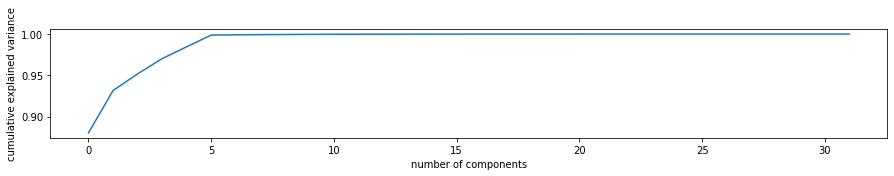

In [18]:
pca = PCA().fit(selected_df.drop(columns = ['home_win', 'year']))

plt.figure(figsize = (15, 2))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

As we can see, nearly all of the variance can be explained with the first five eigenvectors.

In [19]:
train = selected_df[selected_df.year < 2019].reset_index(drop = True)
test = selected_df[selected_df.year == 2019].reset_index(drop = True)

train_target = np.array(train.home_win)
test_target = np.array(test.home_win)

train = train.drop(columns = ['home_win', 'year'])
test = test.drop(columns = ['home_win', 'year'])

pca = PCA(n_components = 5)
pca.fit(train)
xtrain = pca.transform(train)
xtest = pca.transform(test)

In [24]:
n_cols = xtrain.shape[1]
#train base model with base architecture.. this is a proof of concept test, if there are viable results here
#we will move on to tuning parameters and architecture
base_model = Sequential()
base_model.add(Dense(50, activation = 'relu', input_shape = (n_cols,)))
base_model.add(Dense(50, activation = 'relu'))
base_model.add(Dense(50, activation = 'relu'))
base_model.add(Dense(1, activation = 'sigmoid'))

base_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['binary_accuracy'])

base_model.fit(xtrain, train_target, epochs = 50, validation_split = 0.2)

Train on 17466 samples, validate on 4367 samples
Epoch 1/50
17466/17466 [==============================] - 1s 82us/sample - loss: 1.1104 - binary_accuracy: 0.5263 - val_loss: 0.8370 - val_binary_accuracy: 0.5732
Epoch 2/50
17466/17466 [==============================] - 1s 52us/sample - loss: 0.7637 - binary_accuracy: 0.5295 - val_loss: 0.7259 - val_binary_accuracy: 0.5885
Epoch 3/50
17466/17466 [==============================] - 1s 51us/sample - loss: 0.7272 - binary_accuracy: 0.5424 - val_loss: 0.7365 - val_binary_accuracy: 0.5610
Epoch 4/50
17466/17466 [==============================] - 1s 50us/sample - loss: 0.7178 - binary_accuracy: 0.5400 - val_loss: 0.7155 - val_binary_accuracy: 0.5851
Epoch 5/50
17466/17466 [==============================] - 1s 50us/sample - loss: 0.6978 - binary_accuracy: 0.5547 - val_loss: 0.7078 - val_binary_accuracy: 0.5072
Epoch 6/50
17466/17466 [==============================] - 1s 50us/sample - loss: 0.6927 - binary_accuracy: 0.5559 - val_loss: 0.6818 - v

In [25]:
base_preds = base_model.predict(xtest)
base_preds = [i[0] for i in base_preds]

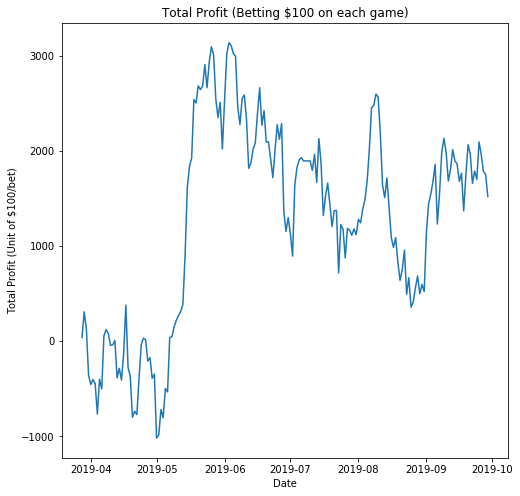

In [26]:
BC = BankrollCalculator(base_preds, test_target, test['home_closing'], test['road_closing'])
BC.play_all()

results_series = pd.Series(BC.outcomes)
result_tracking = pd.concat([Test.date, results_series], axis = 1)
result_tracking = result_tracking.rename(columns = {0 : 'outcome'})
result_tracking['date'] = pd.to_datetime(result_tracking['date'], format = '%Y-%m-%d')
result_tracking = result_tracking.set_index('date')
daily_ = result_tracking.resample('D').sum()
daily_['tracker'] = daily_.outcome.cumsum()

#plot baseline betting 
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(daily_.index, daily_.tracker)
ax.set_xlabel('Date')
ax.set_ylabel('Total Profit (Unit of $100/bet)')
ax.set_title('Total Profit (Betting $100 on each game)');


REMINDER! You selected the .play_some method... Extract play indices with .play_indices attr


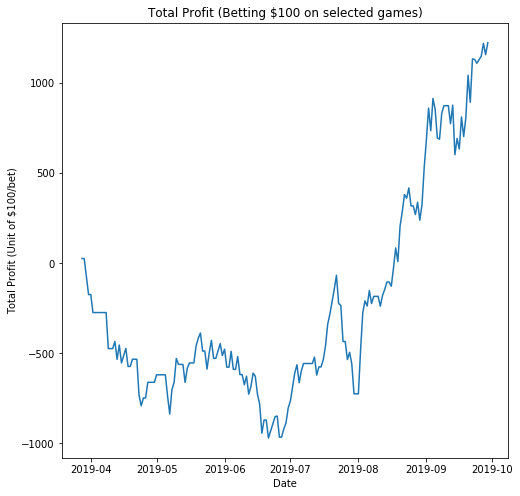

In [27]:
del result_tracking
BC = BankrollCalculator(base_preds, test_target, test['home_closing'], test['road_closing'])
BC.play_some()

results_series = pd.Series(BC.outcomes)
play_indices = BC.play_indices
play_dates = Test.date.iloc[play_indices].reset_index(drop = True)
result_tracking = pd.concat([play_dates, results_series], axis = 1)
result_tracking = result_tracking.rename(columns = {0 : 'outcome'})
result_tracking['date'] = pd.to_datetime(result_tracking['date'], format = '%Y-%m-%d')
result_tracking = result_tracking.set_index('date')
daily_ = result_tracking.resample('D').sum()
daily_['tracker'] = daily_.outcome.cumsum()

#plot baseline betting 
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(daily_.index, daily_.tracker)
ax.set_xlabel('Date')
ax.set_ylabel('Total Profit (Unit of $100/bet)')
ax.set_title('Total Profit (Betting $100 on selected games)');

In [61]:
train_target = np.array(train_target).astype('float32')

In [62]:
train_odds1 = np.array(moneyline_frame[moneyline_frame.year < 2019].home_payout).astype('float32')
train_odds2 = np.array(moneyline_frame[moneyline_frame.year < 2019].road_payout).astype('float32')

In [67]:
#train base model with base architecture.. this is a proof of concept test, if there are viable results here
#we will move on to tuning parameters and architecture
base_model = Sequential()
base_model.add(Dense(50, activation = 'relu', input_shape = (n_cols,)))
base_model.add(Dense(50, activation = 'relu'))
base_model.add(Dense(50, activation = 'relu'))
base_model.add(Dense(1, activation = 'sigmoid'))

base_model.compile(optimizer = 'adam', loss = gambling_loss(train_odds1, train_odds2) , metrics = ['binary_accuracy'])

base_model.fit(xtrain, train_target, epochs = 50, validation_split = 0.0)

Train on 21833 samples
Epoch 1/50
21833/21833 [==============================] - 3s 156us/sample - loss: -74192.7437 - binary_accuracy: 0.5442
Epoch 2/50
21833/21833 [==============================] - 3s 141us/sample - loss: -157042.3289 - binary_accuracy: 0.5731
Epoch 3/50
21833/21833 [==============================] - 3s 141us/sample - loss: -156669.3973 - binary_accuracy: 0.5728
Epoch 4/50
21833/21833 [==============================] - 3s 141us/sample - loss: -156703.1705 - binary_accuracy: 0.5728
Epoch 5/50
21833/21833 [==============================] - 3s 143us/sample - loss: -156802.0918 - binary_accuracy: 0.5729
Epoch 6/50
21833/21833 [==============================] - 3s 141us/sample - loss: -156783.5166 - binary_accuracy: 0.5729
Epoch 7/50
21833/21833 [==============================] - 3s 143us/sample - loss: -156729.5765 - binary_accuracy: 0.5729
Epoch 8/50
21833/21833 [==============================] - 3s 147us/sample - loss: -156818.5444 - binary_accuracy: 0.5729
Epoch 9/50

In [66]:
#This is a custom loss function
def gambling_loss(odds1, odds2):
    ''' House callable for neural network here'''
    O1 = K.constant(odds1)
    O2 = K.constant(odds2)
    _one = K.constant(1)
    def loss(ytrue, ypreds):
        return(-K.sum((O1*ytrue - _one)*K.relu(O1*ypreds - _one) +
         (O2*(_one-ytrue) - _one)*K.relu(O2*(_one - ypreds) - _one)) )
    return(loss)